# 实验三：参数估计 & 非参数估计
- 姓名：胡博浩
- 学号：2212998
- 专业：信息安全

## 实验要求
### 截止日期：11月3日
### 基本要求
生成两个各包含 N=1000 个二维随机向量的数据集合 $X_1$ 和 $X_2$，数据集合中随机向量来自于三个分布模型，分别满足均值向量 $\mu_1=[1,4]$,$\mu_2=[4,1]$, $\mu_3=[8,4]$ 和协方差矩阵 $D_1=D_2=D_3=2\pmb{I}$ ，其中$\pmb{I}$是 $2*2$的单位矩阵。在生成数据集合 $X_1$ 时，假设来自三个分布模型的先验概率相同 ；而在生成数据集合 $X_2$ 时，先验概率如下：$p(w_1)=0.6$, $p(w_2)=0.3$, $p(w_3)=0.1$


<img src="https://i.loli.net/2021/03/31/7WT8naYPQc9N56x.png" alt="image.png" style="zoom: 40%;" /> 
<img src="https://i.loli.net/2021/03/31/qsetFODzM7IhYaN.png" alt="image.png" style="zoom:40%;" />

在两个数据集合上分别应用“似然率测试规则” 和“最大后验概率规则” 进行分类实验，计算分类错误率，分析实验结果。


### 中级要求
在两个数据集合上使⽤高斯核函数估计⽅法，应⽤“似然率测试规则”分类和“最大后验概率规则”在 [0.1, 0.5, 1, 
1.5, 2] 范围内交叉验证找到最优 h 值，分析实验结果

### 高级要求
在两个数据集合上使⽤进⾏k-近邻概率密度估计，计算并分析 k=1，3，5 时的概率密度估计
结果

**环境**：conda python 3.9.18 + vscode

代码都进行了适当注释和分析，感谢助教的批阅！辛苦！

---

## 导入需要的包

首先导入必要的Python库：

numpy用于数学运算，matplotlib.pyplot用于绘图，以及sklearn.model_selection中的KFold用于交叉验证。

In [273]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

## 基本要求

### 数据生成

按照题目要求，定义每个数据集的大小、三个分布模型的均值向量、协方差矩阵

In [274]:
# 定义数据集的参数
N = 1000  # 数据集大小
mu1 = np.array([1, 4])  # 第一个分布模型的均值向量
mu2 = np.array([4, 1])  # 第二个分布模型的均值向量
mu3 = np.array([8, 4])  # 第三个分布模型的均值向量
cmatrix = 2 * np.identity(2)  # 协方差矩阵，2倍的单位矩阵

生成 X1 数据集，先验概率相同

注意：这里X1的先验概率进行了一个小近似，实际上由于1000不能被3整除，先验概率实际上变成了333：333：334

In [275]:
n_per_class = N // 3 # 每个类别的样本数
x1_1 = np.random.multivariate_normal(mu1, cmatrix, n_per_class) # 生成多元正态分布样本
x1_2 = np.random.multivariate_normal(mu2, cmatrix, n_per_class)
x1_3 = np.random.multivariate_normal(mu3, cmatrix, N - 2 * n_per_class)
X1 = np.vstack((x1_1, x1_2, x1_3)) # 生成X1数据集
y1 = np.array([0]*n_per_class + [1]*n_per_class + [2]*(N - 2 * n_per_class)) # 定义标签

生成 X2 数据集，先验概率不同

In [276]:
num1 = int(0.6 * N) # 将数据集分成三部分，分别占总数据集的 60%、30% 和 10%
num2 = int(0.3 * N)
num3 = N - num1 - num2
x2_1 = np.random.multivariate_normal(mu1, cmatrix, num1) # 生成三个多元正态分布的数据集
x2_2 = np.random.multivariate_normal(mu2, cmatrix, num2)
x2_3 = np.random.multivariate_normal(mu3, cmatrix, num3)
X2 = np.vstack((x2_1, x2_2, x2_3)) # 生成X2数据集
y2 = np.array([0]*num1 + [1]*num2 + [2]*num3) # 定义标签

### 可视化

使用matplotlib绘制了两个数据集的散点图，以可视化数据分布

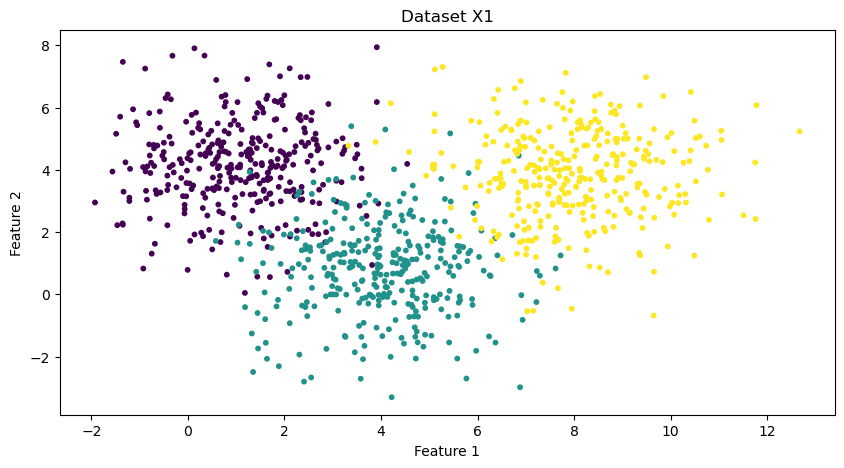

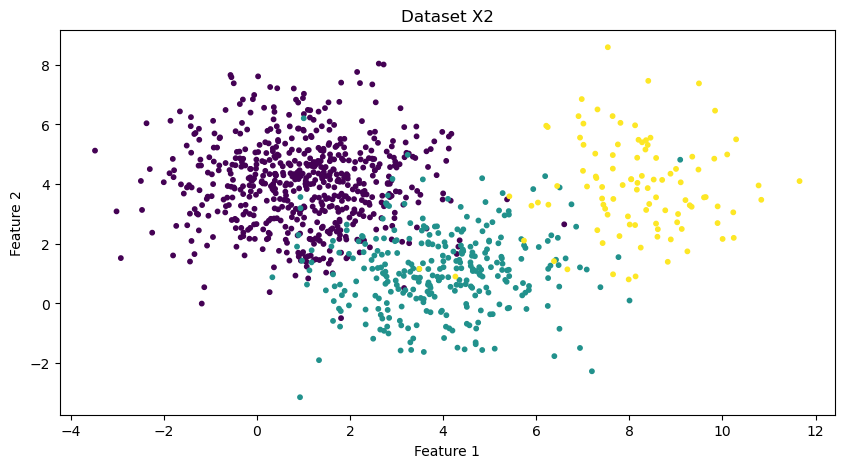

In [277]:
# 可视化数据集X1
plt.figure(figsize=(10, 5))
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap='viridis', s=10)
plt.title('Dataset X1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# 可视化数据集X2
plt.figure(figsize=(10, 5))
plt.scatter(X2[:, 0], X2[:, 1], c=y2, cmap='viridis', s=10)
plt.title('Dataset X2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### 使用参数进行分类

#### 似然率测试规则
对于多元高斯分布，概率密度函数为:

$ p(x\mid\mu,\Sigma)=\frac{1}{(2\pi)^{p/2}|\Sigma|^{1/2}} e^{-\frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu)} $

根据上述公式可以计算出给定数据点属于某个类的似然度。

In [ ]:
# 计算高斯分布的概率密度函数
def gauss(x, mu, sigma):
    p = len(mu) # 特征数
    sigma_inv = np.linalg.inv(sigma) # 协方差矩阵的逆
    sigma_det = np.linalg.det(sigma) # 协方差矩阵的行列式
    norm_const = 1.0 / (np.power((2*np.pi), p/2) * np.sqrt(sigma_det)) 
    x_mu = x - mu
    result = np.dot(x_mu.T, np.dot(sigma_inv, x_mu))
    return norm_const * np.exp(-0.5 * result)

# 基于最大似然估计（MLE）规则进行分类
def predict_mle(X, mus, sigma):
    predictions = []
    for x in X:
        likelihoods = [gauss(x, mu, sigma) for mu in mus] # 计算每个类别的似然度
        predicted_label = np.argmax(likelihoods) # 选择似然度最大的类别
        predictions.append(predicted_label) # 将预测结果添加到列表中
    return np.array(predictions)

#### 最大后验概率规则
MAP 利用高斯分布和先验概率来计算后验概率，从而实现对样本的分类。后验概率是通过将多元高斯分布的概率密度函数与先验概率相乘得到的：

$ \text{posterior} = p(x \mid \mu, \Sigma) \times \text{prior} $

然后通过比较不同类的后验概率，选择后验概率最大的类作为预测结果。

In [278]:
# 使用最大后验概率（MAP）规则进行分类
def predict_map(X, mus, sigma, priors):
    predictions = []
    for x in X:
        posteriors = [gauss(x, mu, sigma) * prior for mu, prior in zip(mus, priors)] # 计算每个类别的后验概率
        predicted_label = np.argmax(posteriors) # 选择后验概率最大的类别
        predictions.append(predicted_label) # 将预测结果添加到列表中
    return np.array(predictions)

对 X1 数据集进行分类

In [279]:
mus = [mu1, mu2, mu3] # 定义均值向量
sigma = cmatrix # 定义协方差矩阵
priors_X1 = [1/3, 1/3, 1/3] # 定义先验概率

y1_pred_mle = predict_mle(X1, mus, sigma) # 使用 MLE 规则进行分类
error_rate_X1_mle = np.mean(y1_pred_mle != y1)
print(f"X1 数据集使用 MLE 的错误率: {error_rate_X1_mle * 100:.2f}%")

y1_pred_map = predict_map(X1, mus, sigma, priors_X1) # 使用 MAP 规则进行分类
error_rate_X1_map = np.mean(y1_pred_map != y1)
print(f"X1 数据集使用 MAP 的错误率: {error_rate_X1_map * 100:.2f}%")

X1 数据集使用 MLE 的错误率: 6.50%
X1 数据集使用 MAP 的错误率: 6.50%


对 X2 数据集进行分类

In [280]:
priors_X2 = [0.6, 0.3, 0.1] # 定义先验概率

y2_pred_mle = predict_mle(X2, mus, sigma) # 使用 MLE 规则进行分类
error_rate_X2_mle = np.mean(y2_pred_mle != y2)
print(f"X2 数据集使用 MLE 的错误率: {error_rate_X2_mle * 100:.2f}%")

y2_pred_map = predict_map(X2, mus, sigma, priors_X2) # 使用 MAP 规则进行分类
error_rate_X2_map = np.mean(y2_pred_map != y2)
print(f"X2 数据集使用 MAP 的错误率: {error_rate_X2_map * 100:.2f}%")

X2 数据集使用 MLE 的错误率: 7.50%
X2 数据集使用 MAP 的错误率: 6.40%


### 结果分析

**X1 数据集分析**：

在两种不同的规则下，错误率均非常低，均为6.50%。这一结果表明，由于X1数据集中三个分布模型的先验概率相同，因此无论是采用似然率规则还是最大后验概率规则，得到的结果都是一样的。

**X2 数据集分析**：

对于X2数据集而言，一般来说，最大后验概率（MAP）规则下的分类错误率要比极大似然估计（MLE）规则下的分类错误率更小。具体来说，MLE规则的错误率为7.50%，而MAP规则则为6.40%。这种差异可能源于X2数据集中三个分布模型具有不同的先验概率。这意味着，在处理包含不同先验信息的情况下，MAP规则能够更有效地利用这些先验知识来提高分类精度。特别是当面对样本类别分布极不平衡时，结合使用先验信息可以显著提升分类性能。

## 中级要求

### 高斯核函数估计

高斯核函数常用于核密度估计中，用于估计概率密度函数。其公式如下：

$ K(x) = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{(2\pi h^2)^{1/2}} \exp\left(-\frac{|x - x_i|^2}{2h^2}\right) $

而高斯核函数估计就是利用高斯核函数对数据集中的每个点进行加权求和，从而估计出点 x 的密度。高斯核函数的带宽参数 h 控制了核的宽度，影响了密度估计的平滑程度。

In [282]:
# 计算一个点 x 在数据集 data 中的核密度估计值
def gauss_kernel(x, data, h):
    diff = data - x
    exponent = -0.5 * np.sum((diff / h) ** 2, axis=1)
    kernel_values = (1 / (2 * np.pi * h ** 2)) * np.exp(exponent)
    return np.sum(kernel_values) / len(data)

定义predict_kernel_mle和predict_kernel_map函数使用高斯核函数估计进行分类。

In [283]:
# 使用高斯核函数估计进行分类（MLE规则）
def predict_kernel_mle(X, datasets, h):
    predictions = []
    for x in X:
        densities = [gauss_kernel(x, data, h) for data in datasets] # 计算每个类别的核密度估计值
        predicted_label = np.argmax(densities) # 选择核密度估计值最大的类别
        predictions.append(predicted_label) # 将预测结果添加到列表中
    return np.array(predictions)

# 使用高斯核函数估计进行分类（MAP规则）
def predict_kernel_map(X, datasets, h, priors):
    predictions = []
    for x in X:
        densities = [gauss_kernel(x, data, h) * prior for data, prior in zip(datasets, priors)] # 计算每个类别的核密度估计值
        predicted_label = np.argmax(densities) # 选择核密度估计值最大的类别
        predictions.append(predicted_label) # 将预测结果添加到列表中
    return np.array(predictions)

定义cross_validate_kernel函数用于在指定的h值范围内进行交叉验证，找到最优的h值。

这里选择使用10折交叉验证的方法来评估平均错误率，从而找到最优的h

In [284]:
# 在指定的h值范围内进行交叉验证，找到最优的h值
def cross_validate_kernel(X, y, hs, priors, rule='mle'):
    kf = KFold(n_splits=10, shuffle=True, random_state=42) # 10折交叉验证
    errors = {h: [] for h in hs} # 存储每个h值的错误率
    for train_index, test_index in kf.split(X): # 对每一折进行训练和测试
        X_train, X_test = X[train_index], X[test_index] # 划分训练集和测试集
        y_train, y_test = y[train_index], y[test_index]
        datasets = [X_train[y_train == c] for c in np.unique(y_train)] # 划分训练集中的类别
        for h in hs: # 对每个h值进行测试
            if rule == 'mle':
                y_pred = predict_kernel_mle(X_test, datasets, h) # 使用 MLE 规则进行分类
            elif rule == 'map':
                y_pred = predict_kernel_map(X_test, datasets, h, priors) # 使用 MAP 规则进行分类
            error_rate = np.mean(y_pred != y_test) # 计算错误率
            errors[h].append(error_rate)
    avg_errors = {h: np.mean(errors[h]) for h in hs} # 计算每个h值的平均错误率
    best_h = min(avg_errors, key=avg_errors.get) # 找到平均错误率最小的h值
    return best_h, avg_errors

在指定的 h 范围内寻找最佳 h 值

In [285]:
hs = [0.1, 0.5, 1, 1.5, 2]  # 按照实验要求指定的范围

# 对 X1 数据集
datasets_X1 = [X1[y1 == c] for c in np.unique(y1)] # 划分数据集中的类别
best_h_X1_mle, avg_errors_X1_mle = cross_validate_kernel(X1, y1, hs, priors_X1, rule='mle')
print(f"X1 数据集采用 MLE 规则的最佳 h 值为 {best_h_X1_mle}，平均错误率为 {avg_errors_X1_mle[best_h_X1_mle]*100:.2f}%")

best_h_X1_map, avg_errors_X1_map = cross_validate_kernel(X1, y1, hs, priors_X1, rule='map')
print(f"X1 数据集采用 MAP 规则的最佳 h 值为 {best_h_X1_map}，平均错误率为 {avg_errors_X1_map[best_h_X1_map]*100:.2f}%")

# 对 X2 数据集
datasets_X2 = [X2[y2 == c] for c in np.unique(y2)] # 划分数据集中的类别
best_h_X2_mle, avg_errors_X2_mle = cross_validate_kernel(X2, y2, hs, priors_X2, rule='mle')
print(f"X2 数据集采用 MLE 规则的最佳 h 值为 {best_h_X2_mle}，平均错误率为 {avg_errors_X2_mle[best_h_X2_mle]*100:.2f}%")

best_h_X2_map, avg_errors_X2_map = cross_validate_kernel(X2, y2, hs, priors_X2, rule='map')
print(f"X2 数据集采用 MAP 规则的最佳 h 值为 {best_h_X2_map}，平均错误率为 {avg_errors_X2_map[best_h_X2_map]*100:.2f}%")

X1 数据集采用 MLE 规则的最佳 h 值为 1.5，平均错误率为 6.10%
X1 数据集采用 MAP 规则的最佳 h 值为 1.5，平均错误率为 6.10%
X2 数据集采用 MLE 规则的最佳 h 值为 0.5，平均错误率为 7.40%
X2 数据集采用 MAP 规则的最佳 h 值为 1，平均错误率为 7.00%


### 绘制高斯核密度估计错误率曲线

使用 matplotlib 库来绘制图表，展示了不同 h 下的错误率。

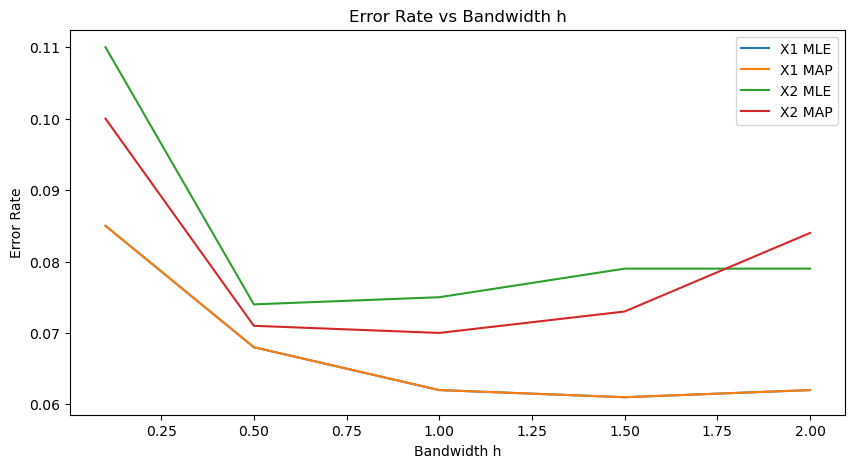

In [286]:
plt.figure(figsize=(10, 5))
plt.plot(hs, list(avg_errors_X1_mle.values()), label='X1 MLE')
plt.plot(hs, list(avg_errors_X1_map.values()), label='X1 MAP')
plt.plot(hs, list(avg_errors_X2_mle.values()), label='X2 MLE')
plt.plot(hs, list(avg_errors_X2_map.values()), label='X2 MAP')
plt.xlabel('Bandwidth h')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Bandwidth h')
plt.legend()
plt.show()

### 结果分析

**X1 数据集**：

- 在X1数据集中，由于三个分布模型的先验概率相同，因此无论是采用似然率规则还是最大后验概率（MAP）规则，得到的结果都是相同的。这一点可以从所用公式中体现出来：当数据集的先验概率均衡时，应用最大后验规则的结果与似然率规则完全一致。

- 对于X1数据集，无论是使用最大似然估计（MLE）规则还是MAP规则，随着带宽参数 h 的增加，错误率都呈现出先下降后上升的趋势。这表明存在一个最优的 h 值，使得分类错误率达到最低。具体来说，在X1数据集中，最优 h 值为1.5，对应的平均错误率为6.10%。

**X2 数据集**：

- 与X1数据集类似，X2数据集中两种规则下的错误率也随 h 的增大而呈现先下降后上升的趋势。然而，在X2数据集中，MLE规则和MAP规则的最优 h 值有所不同，分别为0.5和1。对应的平均错误率分别为7.40%和7.00%。

- 经过多次测试发现，当先验概率差异较大时，采用核函数加最大后验概率规则的效果会更好一些。这表明通过结合先验信息可以改善分类的准确性，特别是对于那些样本数据类别组成十分不均衡的数据集。不过，在X2数据集上，这两种规则之间的差异并不明显，这可能是由于核函数缩小了是否有先验知识对最终错误率的影响。

**带宽参数 h 的影响**：

实验结果还表明，局部核密度估计的性能受到带宽参数 h 的影响显著。选择合适的 h 值对于获得最佳的分类效果至关重要。

- **过小的 h 值**：会导致局部过度拟合，对噪声敏感，容易造成过高的方差和过低的偏差。
- **过大的 h 值**：会导致估计结果过于平滑，丢失局部特征，容易造成过高的偏差和过低的方差。

## 高级要求

### k-近邻密度估计

基于 k 近邻的密度估计方法使用以下公式来计算每个点的密度：

$ \text{density}(i) = \frac{k}{n \cdot V} $

其中：k 是近邻的数量、n 是数据点的总数、V 是以第 k 个最近邻为半径的圆的面积。
 
而计算 V 的公式是：

$ V = \pi \cdot (\text{distances}[k - 1])^2 $

这里的 distances[k - 1] 是第  k  个最近邻的距离。由于假设数据点在二维空间中，因此使用圆的面积公式 $ \pi r^2 $。

这个方法的核心思想是通过第  k  个最近邻的距离来估计局部密度。

In [287]:
# 使用最近邻估计进行密度估计
def knn_density_estimate(data, k):
    num_points = data.shape[0] # 数据集大小
    densities = np.zeros(num_points) # 存储每个点的密度估计值
    for i in range(num_points):
        distances = np.linalg.norm(data - data[i], axis=1)
        # 排除自身距离为零的情况
        distances = np.delete(distances, i)
        distances.sort() # 对距离进行排序
        V = np.pi * (distances[k - 1] ** 2)
        densities[i] = k / (num_points * V) # 计算密度估计值
    return densities

对k=1, 3, 5进行密度估计，并绘制结果图

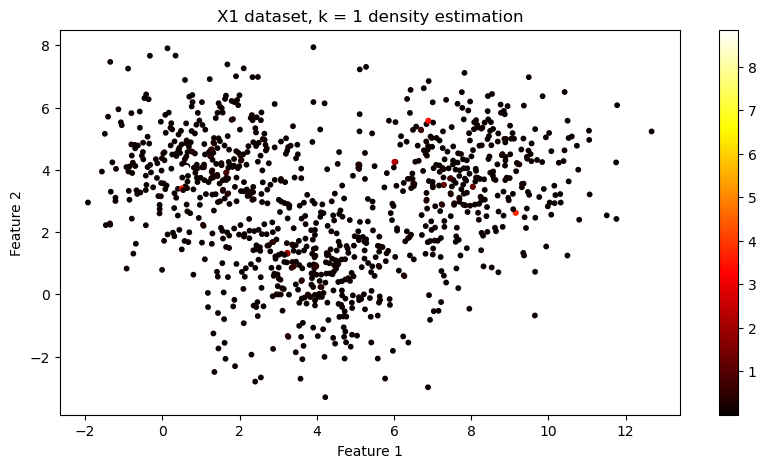

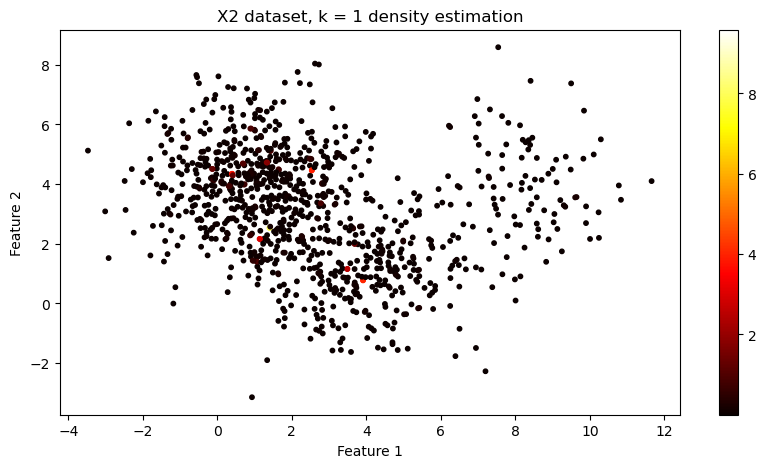

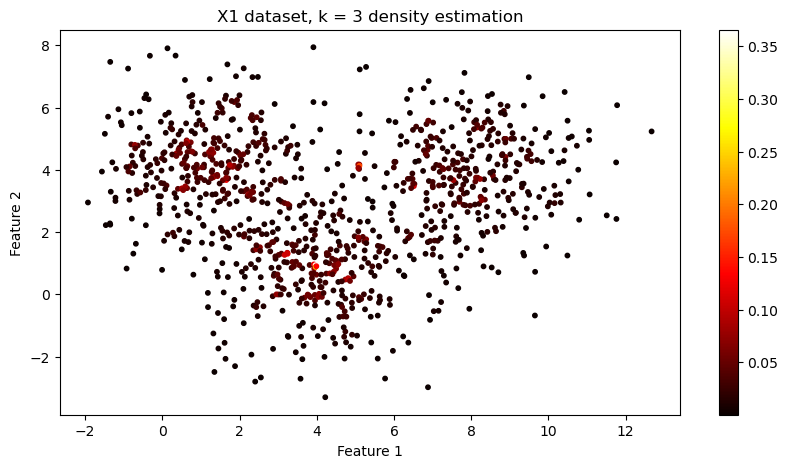

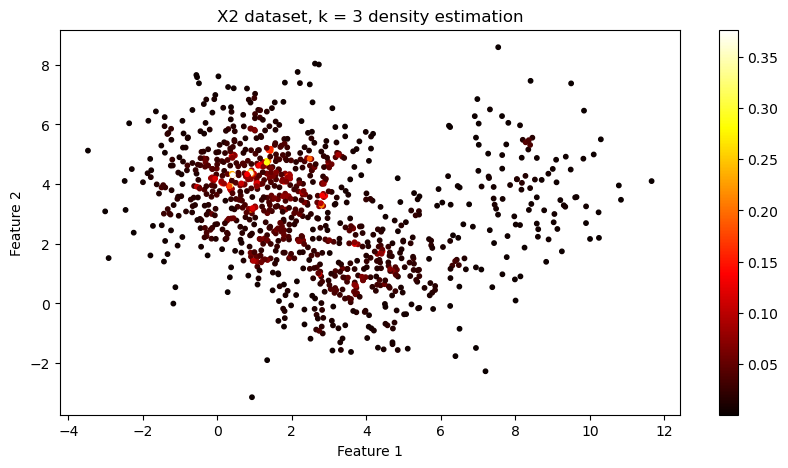

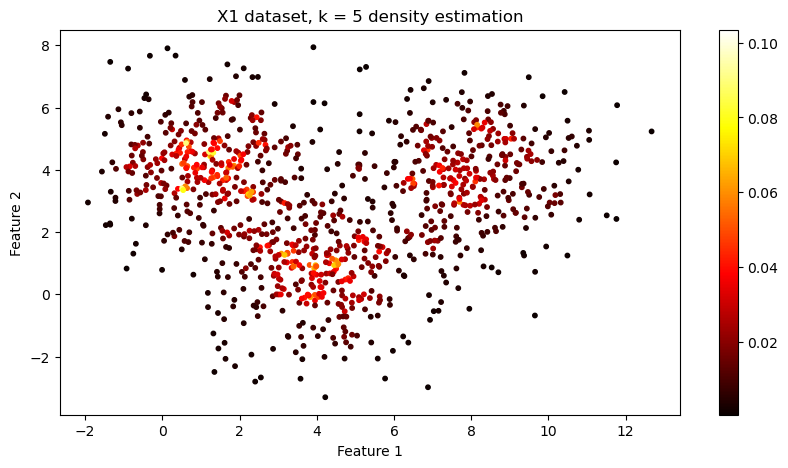

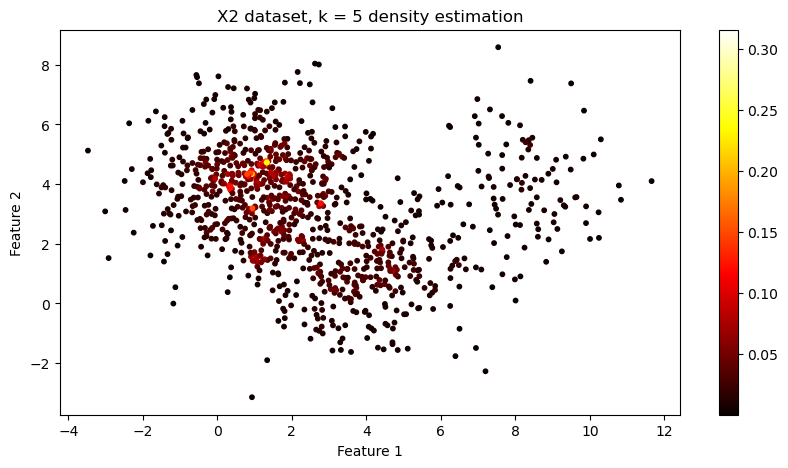

In [288]:
ks = [1, 3, 5] # 按照实验要求指定的范围
for k in ks:
    densities_X1 = knn_density_estimate(X1, k) # 对 X1 数据集进行密度估计
    plt.figure(figsize=(10, 5))
    plt.scatter(X1[:, 0], X1[:, 1], c=densities_X1, cmap='hot', s=10)
    plt.colorbar()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'X1 dataset, k = {k} density estimation')
    plt.show()
    
    densities_X2 = knn_density_estimate(X2, k) # 对 X2 数据集进行密度估计
    plt.figure(figsize=(10, 5))
    plt.scatter(X2[:, 0], X2[:, 1], c=densities_X2, cmap='hot', s=10)
    plt.colorbar()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'X2 dataset, k = {k} density estimation')
    plt.show()

### 结果分析

**X1 数据集分析**：
- **k=1**：热点区域非常集中，都集中在三个均值向量处，即均值向量 (1,4), (4,1) 和 (8,4)。这表明每个数据类都高度集中在各自的均值向量周围，且相互之间重叠较少。
- **k=3**：热点区域开始向周围扩展，但仍能清晰地分辨出三个数据类的分布区域。每个数据类的热点区域呈现出一定的椭圆形，这是由于数据类的协方差矩阵为单位矩阵，导致数据点在各个方向上的分布比较均匀。
- **k=5**：热点区域进一步扩大，三个数据类的分布区域开始模糊，但仍然可以明显看出数据点主要集中在这三个区域。与 k=3 相比，k=5 的热点区域更加平滑，这表明 k 值的增加能够降低噪声的影响，但也可能导致一些局部特征丢失。

**X2 数据集分析**：
- **k=1**：热点区域与 X1 数据集类似，都集中在三个均值向量处，即均值向量 (1,4), (4,1) 和 (8,4)。这说明即使数据类的先验概率不同，k 近邻密度估计仍然能够有效地识别出数据类的中心区域。
- **k=3**：与 X1 数据集相比，X2 数据集中 (1,4) 类型的数据点数量更多，因此其热点区域更大，覆盖了更多的点。这说明 k 近邻密度估计能够反映数据点的数量分布。
- **k=5**：与 X1 数据集相比，X2 数据集中 (1,4) 类型的数据点数量更多，因此其热点区域更大，覆盖了更多的点。这说明 k 值的增加不会改变数据点的数量分布，但会降低噪声的影响，使热点区域更加平滑。

**结果总结**：
- **k 值对密度估计结果有显著影响**。较小的 k 值能够更好地捕捉局部特征，但容易受到噪声的影响；较大的 k 值能够降低噪声的影响，但可能会丢失一些局部特征。
- **数据类的分布对密度估计结果有影响**。数据点数量较多的类别的热点区域更大，覆盖了更多的点。
- **k 近邻密度估计能够有效地估计数据点的局部密度**。通过观察热力图，可以清晰地看出数据点的分布情况，并识别出数据类的中心区域。
- **k 近邻密度估计不受数据类先验概率的影响**。即使数据类的先验概率不同，k 近邻密度估计仍然能够有效地识别出数据类的中心区域。
- **k 近邻密度估计可以反映数据点的数量分布**。通过观察热点区域的面积大小，可以判断不同数据类的数据点数量多少。